In [6]:
#!/usr/bin/env python3

import gpatlas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pandas as pd
from pathlib import Path
from typing import cast
import h5py
import time as tm
from datetime import datetime

In [7]:

#variables
n_phen=2
n_loci = 2000
n_alleles = 2

latent_space_g = 4096
latent_space_g1 = 250

EPS = 1e-15


batch_size = 128
num_workers = 3

base_file_name = 'test_sim_qhaplo_10k_1ksites_100qtl_Ve0_'
base_file_name_out = 'experiments/test_sim_qhaplo_10k_1ksites_100qtl_Ve0_gpnet'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

##########################################################################################
##########################################################################################

loaders = gpatlas.create_data_loaders(base_file_name, batch_size=128, num_workers=3, shuffle=True)

train_loader_geno = loaders['train_loader_geno']
test_loader_geno = loaders['test_loader_geno']

train_loader_pheno = loaders['train_loader_pheno']
test_loader_pheno = loaders['test_loader_pheno']

train_loader_gp = loaders['train_loader_gp']
test_loader_gp = loaders['test_loader_gp']


Using device: cuda


In [8]:
def train_gpnet(model, train_loader, test_loader=None,
                n_loci=None,
                n_alleles=2,
                max_epochs=250,  # Set a generous upper limit
                patience=50,      # Number of epochs to wait for improvement
                min_delta=0.003, # Minimum change to count as improvement
                learning_rate=0.1,
                l1_lambda=None, weight_decay=1e-7,
                # Pruning parameters
                target_sparsity=0.75,  # Target sparsity
                pruning_start=10,     # Start pruning after 10 epochs
                pruning_end=30,       # End pruning at 30 epochs
                device=device):
    """
    Train model with early stopping to prevent overtraining
    and gradual pruning of first layer weights
    """
    # Move model to device
    model = model.to(device)

    # Initialize optimizer with proper weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [],
        'test_loss': [],
        'epochs_trained': 0,
        'sparsity': []  # Track sparsity level
    }

    # Early stopping variables
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0

        for i, (phens, gens) in enumerate(train_loader):

            phens = phens.to(device)
            gens = gens[:, : n_loci * n_alleles]
            gens = gens.to(device)

            # Forward pass
            optimizer.zero_grad()
            output = model(gens)

            # focal loss
            g_p_recon_loss = F.l1_loss(output + EPS, phens + EPS)

            first_layer_l1 = 0

            for name, param in model.named_parameters():
                # Check if the parameter belongs to the first linear layer
                if 'gpnet.0.weight' in name:
                    first_layer_l1 += torch.sum(torch.abs(param))

            # Combined loss with L1 penalty
            g_p_recon_loss = g_p_recon_loss + l1_lambda * first_layer_l1

            # Backward and optimize
            g_p_recon_loss.backward()
            optimizer.step()

            train_loss += g_p_recon_loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Apply gradual pruning if in pruning phase
        current_sparsity = 0
        if hasattr(model, 'gradual_prune') and epoch >= pruning_start and epoch <= pruning_end:
            current_sparsity = model.gradual_prune(
                target_sparsity,
                epoch - pruning_start,
                pruning_end - pruning_start
            )
            history['sparsity'].append(current_sparsity)
            print(f"Applied pruning - current sparsity: {current_sparsity:.4f}")
        elif hasattr(model, 'get_sparsity_stats'):
            stats = model.get_sparsity_stats()
            current_sparsity = stats["sparsity"]
            history['sparsity'].append(current_sparsity)
        else:
            history['sparsity'].append(0)

        # Validation
        if test_loader is not None:
            model.eval()
            test_loss = 0

            with torch.no_grad():
                for phens, gens in test_loader:
                    phens = phens.to(device)
                    gens = gens[:, : n_loci * n_alleles]
                    gens = gens.to(device)

                    output = model(gens)
                    test_loss += F.l1_loss(output + EPS, phens + EPS)

            avg_test_loss = test_loss / len(test_loader)
            history['test_loss'].append(avg_test_loss)

            print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {avg_test_loss:.6f}, Sparsity: {current_sparsity:.4f}')

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Check for improvement
            if avg_test_loss < (best_loss - min_delta):
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
                print(f"New best model at epoch {epoch+1} with test loss: {best_loss:.6f}")
            else:
                patience_counter += 1
                print(f"No improvement for {patience_counter} epochs (best: {best_loss:.6f})")

            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were actually used
    history['epochs_trained'] = epoch + 1

    # Restore best model
    if best_model_state is not None:
        print(f"Restoring best model from epoch {best_epoch+1}")
        model.load_state_dict(best_model_state)

    # Report final pruning statistics if available
    if hasattr(model, 'get_sparsity_stats'):
        final_stats = model.get_sparsity_stats()
        print(f"Final model sparsity: {final_stats['sparsity']:.4f}")
        print(f"Active weights in first layer: {final_stats['active_weights']} / {final_stats['total_weights']}")

    return model, best_loss, history

In [9]:

def run_full_pipeline():
    """
    Objective function for Optuna that uses early stopping
    """
    model = gpatlas.GP_net_btl(
    n_loci=n_loci,
    latent_space_g=latent_space_g,
    latent_space_g1=latent_space_g1,
    n_pheno=n_phen,
    )

    model, best_loss_gp, history = train_gpnet(model=model,
                                            train_loader=train_loader_gp,
                                            test_loader=test_loader_gp,
                                            n_loci=n_loci,
                                            device=device,
                                            l1_lambda=0,
                                            target_sparsity=0.80,
                                            pruning_start=10,
                                            pruning_end=50)
    model.eval()

    #visualize results
    true_phenotypes = []
    predicted_phenotypes = []

    with torch.no_grad():
        for phens, gens in test_loader_gp:
            phens = phens.to(device)
            gens = gens.to(device)

            # Get predictions
            predictions = model(gens)

            # Store results
            true_phenotypes.append(phens.cpu().numpy())
            predicted_phenotypes.append(predictions.cpu().numpy())

    # Concatenate batches
    true_phenotypes = np.concatenate(true_phenotypes)
    predicted_phenotypes = np.concatenate(predicted_phenotypes)

    # Calculate correlations for each phenotype
    correlations = []
    p_values = []
    for i in range(n_phen):
        corr, p_val = pearsonr(true_phenotypes[:, i], predicted_phenotypes[:, i])
        correlations.append(corr)
        p_values.append(p_val)

    # Create a detailed DataFrame with all results
    results_df = pd.DataFrame({
        'trait_number': range(1, n_phen + 1),
        'pearson_correlation': correlations,
        'p_value': p_values,
        'true_mean': [np.mean(true_phenotypes[:, i]) for i in range(n_phen)],
        'pred_mean': [np.mean(predicted_phenotypes[:, i]) for i in range(n_phen)],
        'true_std': [np.std(true_phenotypes[:, i]) for i in range(n_phen)],
        'pred_std': [np.std(predicted_phenotypes[:, i]) for i in range(n_phen)]
    })

    # Save to CSV
    results_df.to_csv(f'{base_file_name_out}_pheno_corr.csv', index=False)

    print(corr)
    print(best_loss_gp)

    model.eval()
    return model


In [10]:
result = run_full_pipeline()


Epoch: 1/250, Train Loss: 1.220226, Test Loss: 0.986925, Sparsity: 0.0000
New best model at epoch 1 with test loss: 0.986925
Epoch: 2/250, Train Loss: 0.818077, Test Loss: 0.778146, Sparsity: 0.0000
New best model at epoch 2 with test loss: 0.778146
Epoch: 3/250, Train Loss: 0.702478, Test Loss: 0.770090, Sparsity: 0.0000
New best model at epoch 3 with test loss: 0.770090
Epoch: 4/250, Train Loss: 0.646431, Test Loss: 0.771743, Sparsity: 0.0000
No improvement for 1 epochs (best: 0.770090)
Epoch: 5/250, Train Loss: 0.603807, Test Loss: 0.764178, Sparsity: 0.0000
New best model at epoch 5 with test loss: 0.764178
Epoch: 6/250, Train Loss: 0.553147, Test Loss: 0.783970, Sparsity: 0.0000
No improvement for 1 epochs (best: 0.764178)
Epoch: 7/250, Train Loss: 0.500807, Test Loss: 0.856116, Sparsity: 0.0000
No improvement for 2 epochs (best: 0.764178)
Epoch: 8/250, Train Loss: 0.476133, Test Loss: 0.791996, Sparsity: 0.0000
No improvement for 3 epochs (best: 0.764178)
Epoch: 9/250, Train Loss

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

def visualize_bottleneck_weights(model, n_loci, top_n=20):
    """
    Visualize the weights of the bottleneck layer to see which input features (QTLs)
    are most important to each neuron.

    Args:
        model: Trained neural network model
        n_loci: Number of input loci
        top_n: Number of top weights to highlight per neuron
    """
    # Extract first layer weights
    first_layer_weights = model.fc1.weight.detach().cpu().numpy()


    if first_layer_weights is None:
        print("Couldn't find bottleneck layer weights")
        return

    # Get dimensions
    n_neurons, n_inputs = first_layer_weights.shape

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Overall weight distribution
    plt.subplot(2, 2, 1)
    sns.histplot(first_layer_weights.flatten(), bins=100)
    plt.title('Distribution of Weights in Bottleneck Layer')
    plt.xlabel('Weight Value')

    # 2. Heatmap of weights (first 20 neurons x first 50 inputs)
    plt.subplot(2, 2, 2)
    sns.heatmap(first_layer_weights[:min(20, n_neurons), :min(50, n_inputs)],
                cmap='coolwarm', center=0)
    plt.title('Weight Heatmap (subset)')
    plt.xlabel('Input Features (QTLs)')
    plt.ylabel('Neurons in Bottleneck Layer')

    # 3. L1 norm per neuron (which neurons are most active?)
    neuron_activity = np.abs(first_layer_weights).sum(axis=1)
    plt.subplot(2, 2, 3)
    sns.barplot(x=np.arange(min(50, n_neurons)), y=neuron_activity[:min(50, n_neurons)])
    plt.title('Neuron Activity (L1 Norm of Weights)')
    plt.xlabel('Neuron Index')
    plt.ylabel('Total Weight Magnitude')

    # 4. Feature importance (which inputs are most important across all neurons?)
    feature_importance = np.abs(first_layer_weights).sum(axis=0)
    sorted_indices = np.argsort(-feature_importance)  # Sort in descending order
    plt.subplot(2, 2, 4)
    sns.barplot(x=np.arange(min(50, n_inputs)),
                y=feature_importance[sorted_indices[:min(50, n_inputs)]])
    plt.title('QTL Importance Across All Neurons')
    plt.xlabel('QTL Index (Sorted by Importance)')
    plt.ylabel('Importance')

    plt.tight_layout()
    plt.show()

    # 5. Specialized neurons: For each neuron, show which inputs it most strongly responds to
    plt.figure(figsize=(15, min(20, n_neurons) * 0.5))
    for i in range(min(10, n_neurons)):
        weights = first_layer_weights[i]
        # Get indices of top weights by magnitude
        top_indices = np.argsort(-np.abs(weights))[:top_n]

        plt.subplot(min(10, n_neurons), 1, i+1)
        plt.bar(top_indices, weights[top_indices], color=['red' if w < 0 else 'blue' for w in weights[top_indices]])
        plt.title(f'Neuron {i}: Top {top_n} Connections')
        plt.xlabel('QTL Index')
        plt.ylabel('Weight')
        plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Return the sorted QTL indices by importance for further analysis
    return sorted_indices

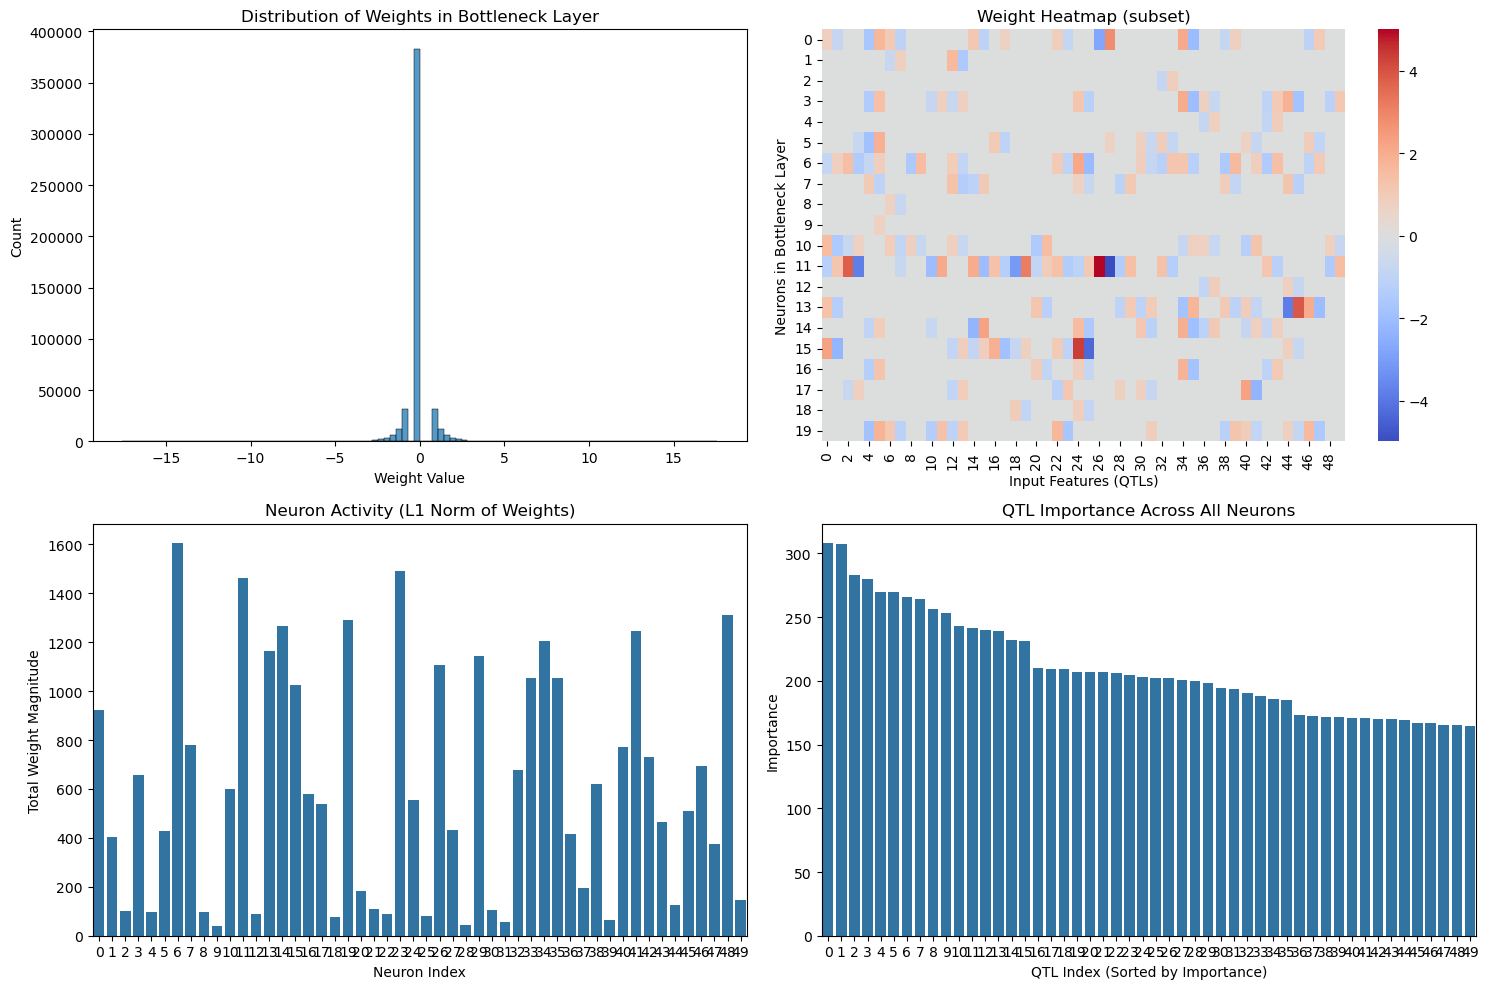

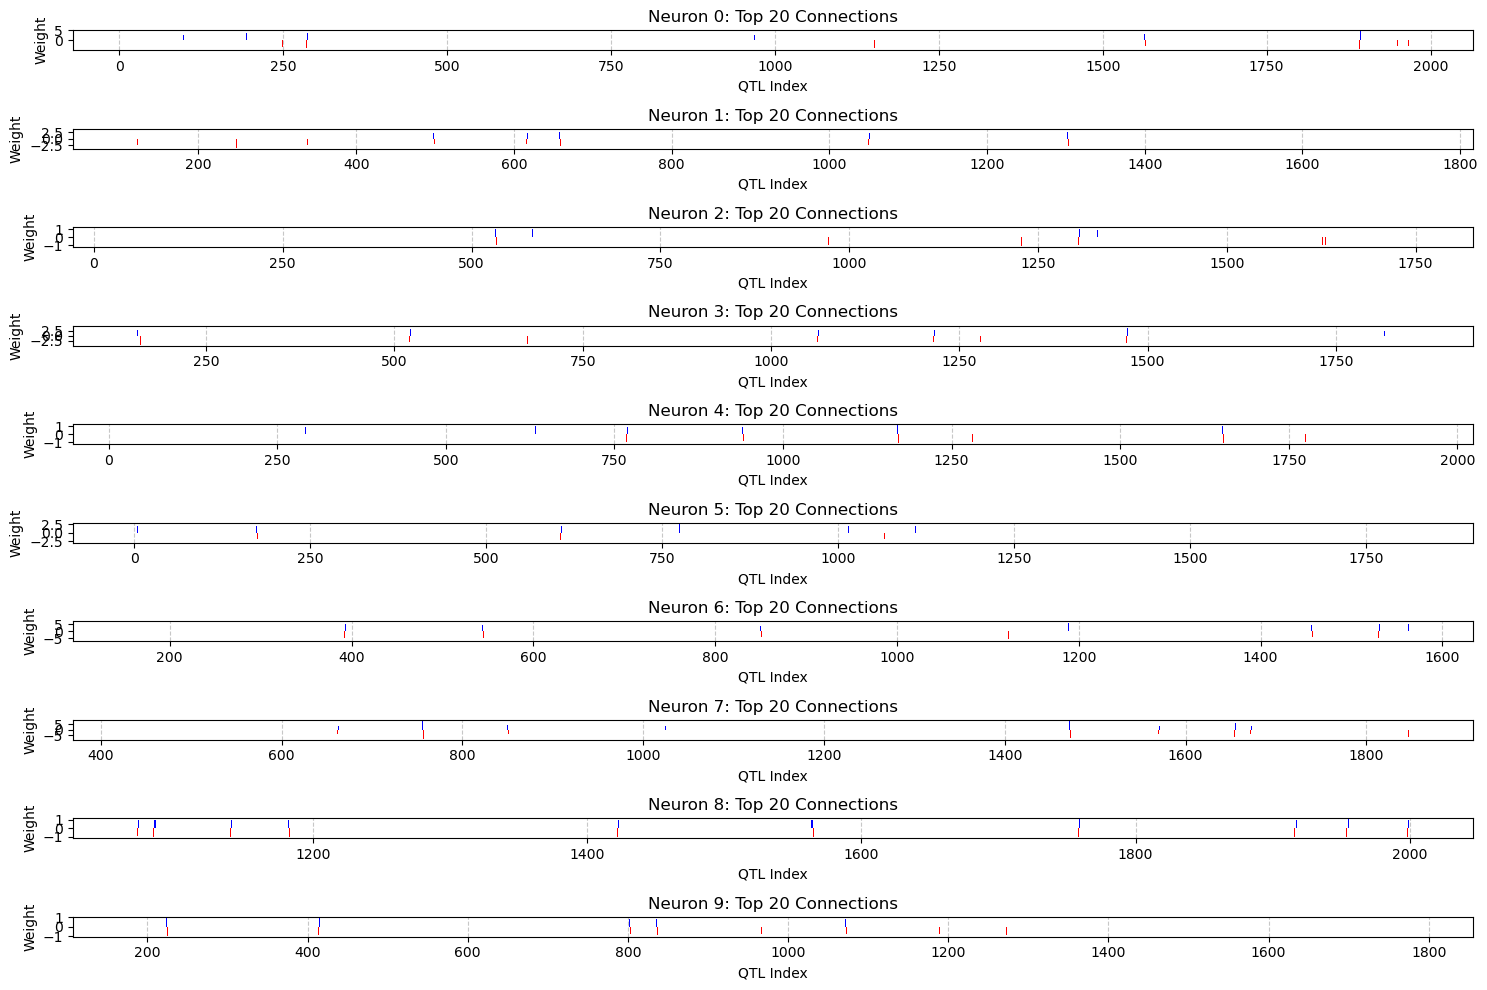

array([657, 656, 159, ..., 472, 503, 502])

In [12]:
visualize_bottleneck_weights(result, 1000)